# Import package

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [189]:
###############################################################################
#Import package
###############################################################################

#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

# interactive plots
import plotly as py
from plotly.offline import iplot, plot, init_notebook_mode, download_plotlyjs
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.offline as offline

#Import common utilities
import math
from collections import Counter

# statsmodels
import pylab
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels as statm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer

# Accuracy Evaluation
from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics
import sklearn.metrics as metrics
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

# Datetime
from datetime import date
import datetime
import calendar
import holidays

# Load data

In [5]:
# Load dataset: calendar
calendar_df = pd.read_csv('D:\\MyProjects\\01_Airbnb\\Data\\seattle_calendar.csv')
calendar_df.shape   # (1393570, 4)

(1393570, 4)

# View data structure and content

#### View content: Look at the first 5 rows

In [7]:
# View data structure and content
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


   * There are 4 columns
   * If the available values are f, the price values seem to be NaN, but it is only a hypothesis, need to check if it is true for all data
   * The price are stored as object, need to convert from string to float
   

#### View structure: data type of all features

In [8]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


#### Check price in case the available values are f

In [7]:
calendar1_df = calendar_df.groupby('available')['price'].count().reset_index()
calendar1_df.columns = ['available', 'price_nonnull_count']
calendar1_df

,available,price_nonnull_count
0,f,0
1,t,934542


   => It is true that if available value is true, then price is NaN

#### Check available days per listing around year

In [13]:
calendar_df.groupby('available')['listing_id'].count().reset_index()

,available,listing_id
0,f,459028
1,t,934542


In [29]:
calendar1_df = calendar_df.groupby(['listing_id','available'])['available'].count().unstack()
calendar1_df.head()

available,f,t
listing_id,,
3335,56.0,309.0
4291,NaN,365.0
5682,56.0,309.0
6606,NaN,365.0
7369,312.0,53.0


In [32]:
calendar1_df = calendar1_df.reset_index()
calendar1_df.head()

available,listing_id,f,t
0,3335,56.0,309.0
1,4291,NaN,365.0
2,5682,56.0,309.0
3,6606,NaN,365.0
4,7369,312.0,53.0


   => For each listing, we can see how many days it is available, how many days it is unvailable

#### How many rows per each listing_id

In [12]:
calendar1_df = calendar_df.groupby('listing_id')['date'].count().reset_index()
calendar1_df['date'].value_counts()

365    3818
Name: date, dtype: int64

   => There are 365 days per listing. This is equal a year

# Check missing data

In [34]:
def Check_Missing_Data(df):    
    # count all missing values of each column
    total = df.isnull().sum().sort_values(ascending=False)
    # calculate percentage of null values for each column
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

Check_Missing_Data(calendar_df)

,Total,Percent
price,459028,0.32939
available,0,0.00000
date,0,0.00000
listing_id,0,0.00000


   => There are around 33% of rows missing price because the property is unavailable

# Data Cleaning

#### Remove missing data

In [192]:
calendar1_df = calendar_df.copy(deep=True)
print('Num or rows before removing NaN: ',calendar1_df.shape[0])
calendar1_df.dropna(inplace=True)
print('Num or rows after removing NaN: ',calendar1_df.shape[0])

Num or rows before removing NaN:  1393570
Num or rows after removing NaN:  934542


#### Convert price from string to float

In [193]:
calendar1_df['price'] = calendar1_df['price'].str.replace("[$, ]", "").astype("float")
calendar1_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
9,241032,2016-01-13,t,85.0
10,241032,2016-01-14,t,85.0
14,241032,2016-01-18,t,85.0


#### Convert date from string to datetime

In [194]:
calendar1_df['date'] = pd.to_datetime(calendar1_df['date'])
calendar1_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
9,241032,2016-01-13,t,85.0
10,241032,2016-01-14,t,85.0
14,241032,2016-01-18,t,85.0


# Business Analysis

### Analyze trends of available listing and price

In [195]:
# available listing by date
df1  = calendar1_df.groupby("date")[["listing_id"]].count()
# calculate sum and average of price by date
df1['sum'] = calendar1_df.groupby("date")[["price"]].sum()
df1["mean"]  = calendar1_df.groupby("date")[["price"]].mean()
df1.head()

,listing_id,sum,mean
date,,,
2016-01-04,1735,211819.0,122.085879
2016-01-05,1867,225312.0,120.681307
2016-01-06,1826,220815.0,120.928258
2016-01-07,1776,214823.0,120.958896
2016-01-08,1782,227456.0,127.640853


In [196]:
df1.columns = ["Count", "Sum","Average"]
df1.index = pd.to_datetime(df1.index)
df1.head()

,Count,Sum,Average
date,,,
2016-01-04,1735,211819.0,122.085879
2016-01-05,1867,225312.0,120.681307
2016-01-06,1826,220815.0,120.928258
2016-01-07,1776,214823.0,120.958896
2016-01-08,1782,227456.0,127.640853


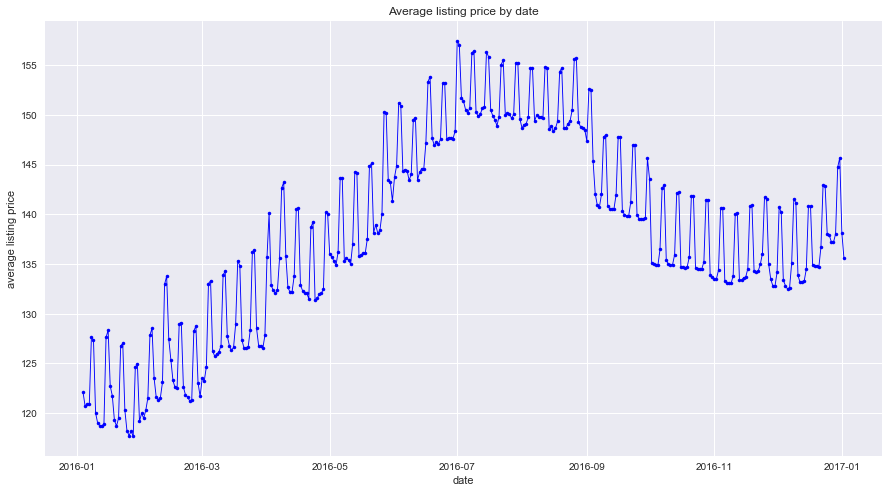

In [201]:
# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(df1.index, df1.Average, color='b', marker='.', linewidth=0.9)
plt.title("Average listing price by date")
plt.xlabel('date')
plt.ylabel('average listing price')
plt.show()

In [203]:
# To view interactive plots, click link below : 
# https://nbviewer.jupyter.org/github/ntmai03/Airbnb/blob/master/AirbnbTimeSeriesAnalysis.ipynb

trace1 = go.Scatter(
    x = df1.index,
    y = df1["Average"]
)
data = [trace1]
layout = go.Layout(
    title = "Price by each time",
    xaxis  = dict(title = "Time"),
    yaxis = dict(title = "Mean ($)")
)

fig1 = go.Figure(data = data, layout = layout)
offline.iplot(fig1)

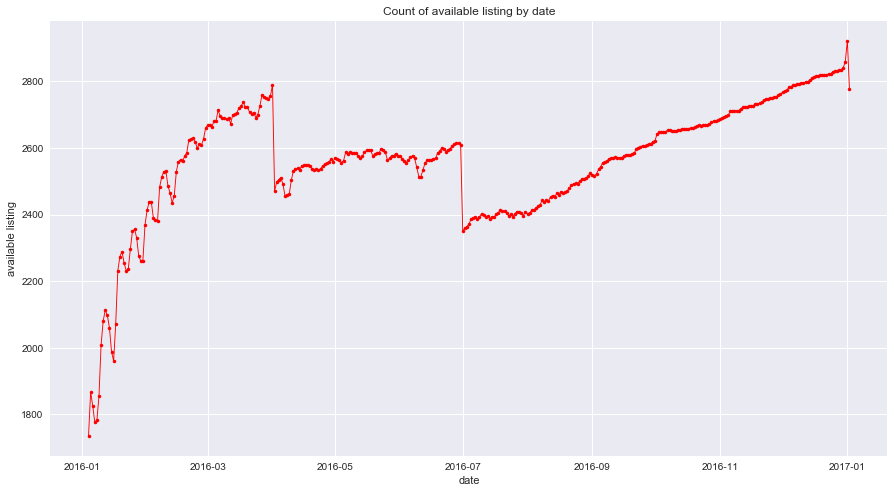

In [64]:
# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(df1.index, df1.Count, color='r', marker='.', linewidth=0.9)
plt.title("Count of available listing by date")
plt.xlabel('date')
plt.ylabel('available listing')
plt.show()

In [204]:
# resample data by month
df2 =  df1[["Count"]].resample("W").mean()
df2['Sum'] =  df1[["Sum"]].resample("W").mean()
df2['Average'] =  df1[["Average"]].resample("W").mean()
df2.head()

,Count,Sum,Average
date,,,
2016-01-10,1835.857143,225376.428571,122.804001
2016-01-17,2053.142857,250284.714286,121.999434
2016-01-24,2259.000000,275299.428571,121.894993
2016-01-31,2314.714286,277838.142857,120.071592
2016-02-07,2418.142857,297400.714286,123.011431


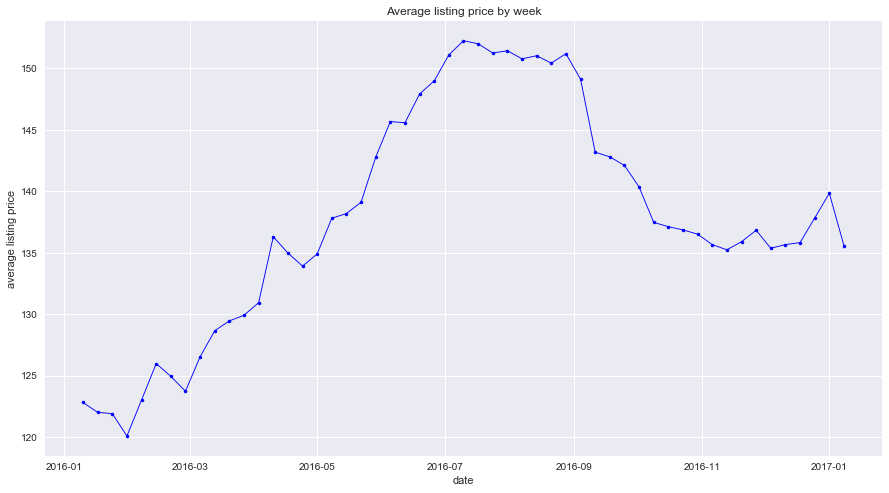

In [205]:
# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(df2.index, df2.Average, color='b', marker='.', linewidth=0.9)
plt.title("Average listing price by week")
plt.xlabel('date')
plt.ylabel('average listing price')
plt.show()

In [207]:
# To view interactive plots, click link below : 
# https://nbviewer.jupyter.org/github/ntmai03/Airbnb/blob/master/AirbnbTimeSeriesAnalysis.ipynb

trace2 = go.Scatter(
    x = df2.index,
    y = df2["Average"]
)
data2 = [trace2]
layout = go.Layout(
    title = "Price by each time",
    xaxis  = dict(title = "Time"),
    yaxis = dict(title = "Mean ($)")
)

fig2 = go.Figure(data = data2, layout = layout)
offline.iplot(fig2)

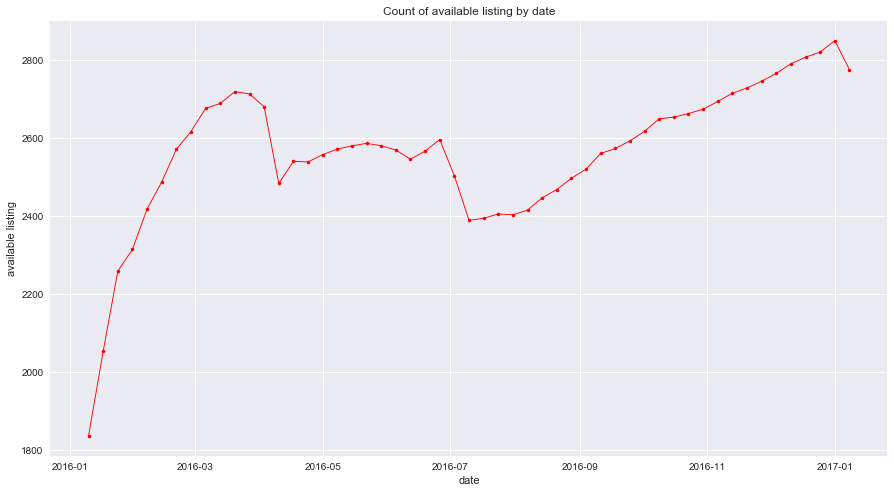

In [70]:
# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(df2.index, df2.Count, color='r', marker='.', linewidth=0.9)
plt.title("Count of available listing by date")
plt.xlabel('date')
plt.ylabel('available listing')
plt.show()

   => This is interesting. there are two trends of data:
      * The average price rise from 01/2016 to 07/2016, and reach the peak for three months, then getting lower. And the average price of 01/2017 is higher than 1 year ago. This trend can be split into two factors: one is seasonal factor and the other is overall factor
      * There is periodic small speak. This looks like weekly pattern. So let's close look at
   

In [88]:
# create weekday column
df1["date"] = df1.index
df1["weekday"] = df1["date"].dt.weekday_name
df1.head()

,Count,Sum,Average,date,weekday
date,,,,,
2016-01-04,1735,211819.0,122.085879,2016-01-04,Monday
2016-01-05,1867,225312.0,120.681307,2016-01-05,Tuesday
2016-01-06,1826,220815.0,120.928258,2016-01-06,Wednesday
2016-01-07,1776,214823.0,120.958896,2016-01-07,Thursday
2016-01-08,1782,227456.0,127.640853,2016-01-08,Friday


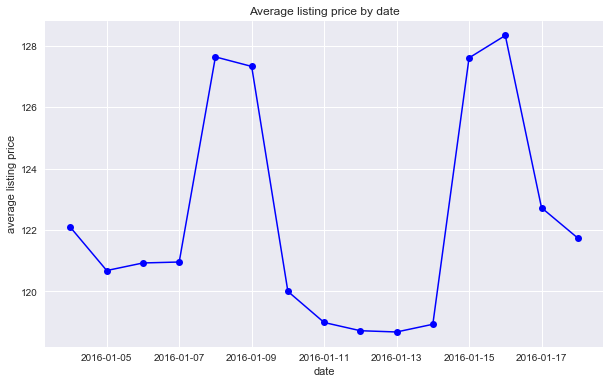

In [95]:
# plot more narrow range
plt.figure(figsize=(10, 6))
plt.plot(df1.index.values[:15], df1.Average.values[:15], color='b', marker='o', linewidth=1.5)
plt.title("Average listing price by date")
plt.xlabel('date')
plt.ylabel('average listing price')
plt.show()

#### Which does weekday have high price ?

In [108]:
df1.groupby('weekday')['Average'].mean()

weekday
Friday       142.964759
Monday       135.637263
Saturday     143.120562
Sunday       136.463607
Thursday     136.382791
Tuesday      135.379666
Wednesday    135.407384
Name: Average, dtype: float64

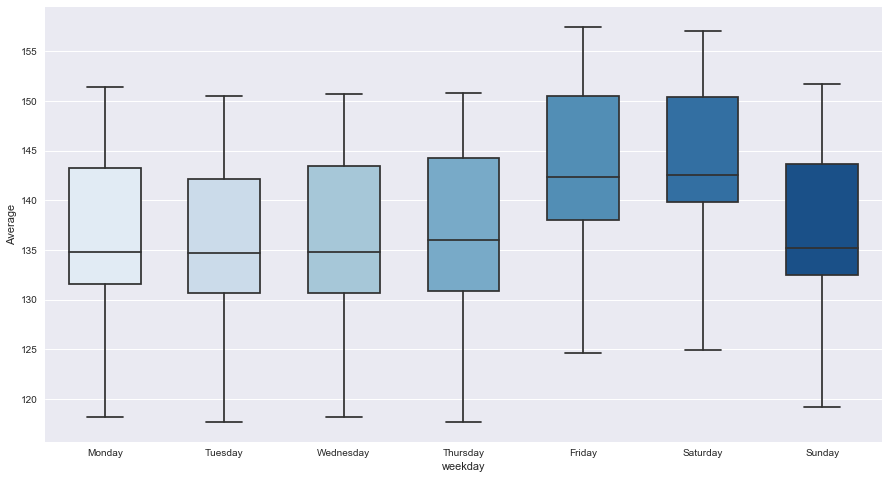

In [89]:
# boxplot to see price distribution
plt.figure(figsize=(15, 8))
sns.boxplot(x = 'weekday',  y = 'Average', data = df1, palette="Blues", width=0.6)
plt.show()

   => The weekend, Friday and Saturday has high price

### Seasonal Pattern of airbnb housing price
   Analyzing how prices of listings vary according to season, month, week, day which constitutes the next analysis

#### Extract year, month, day for each date

In [90]:
# extract year, month for each date
calendar1_df['day'] = calendar1_df.date.dt.day
calendar1_df['year'] = calendar1_df.date.dt.year
calendar1_df['month'] = calendar1_df.date.dt.month

calendar1_df.head()

,listing_id,date,available,price,day,year,month
0,241032,2016-01-04,t,85.0,4,2016,1
1,241032,2016-01-05,t,85.0,5,2016,1
9,241032,2016-01-13,t,85.0,13,2016,1
10,241032,2016-01-14,t,85.0,14,2016,1
14,241032,2016-01-18,t,85.0,18,2016,1


#### Number of listings by month

In [101]:
number_of_listings_by_month = calendar1_df.groupby('month').listing_id.count()
number_of_listings_by_month

month
1     64937
2     73321
3     83938
4     76037
5     79971
6     77244
7     74222
8     76347
9     77246
10    82438
11    81780
12    87061
Name: listing_id, dtype: int64

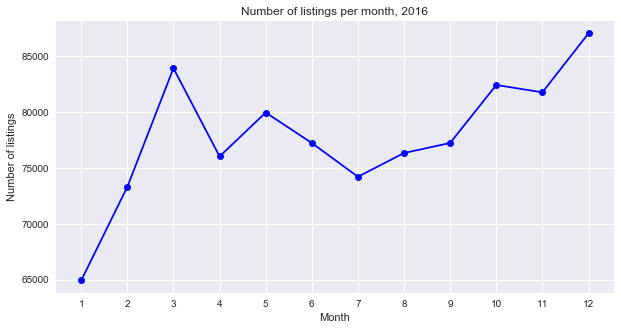

In [103]:
# Line plot
plt.figure(figsize=(10,5))
plt.plot(number_of_listings_by_month.index.values, number_of_listings_by_month.values,color='b', marker='o')
plt.xticks(number_of_listings_by_month.index.values)
plt.ylabel('Number of listings')
plt.xlabel('Month')
plt.title('Number of listings per month, 2016')
plt.show()

#### Average price by month

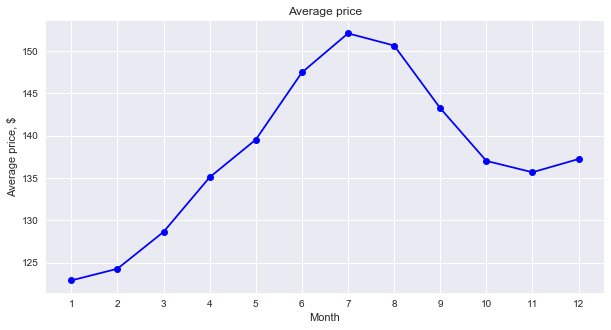

In [106]:
#find average price by month
average_price_by_month = calendar1_df.groupby(['month'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price_by_month,color='b', marker='o')
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price')
plt.xticks(average_price_by_month.index.values)
plt.show()

In [225]:
# resample data by month
df2 =  df1[["Count"]].resample("M").mean()
df2['Sum'] =  df1[["Sum"]].resample("M").mean()
df2['Average'] =  df1[["Average"]].resample("M").mean()
df2.head()

,Count,Sum,Average
date,,,
2016-01-31,2115.678571,257199.678571,121.692505
2016-02-29,2528.310345,314253.620690,124.315614
2016-03-31,2707.677419,348327.774194,128.640797
2016-04-30,2534.566667,342412.366667,135.109460
2016-05-31,2579.709677,359968.000000,139.539566


In [222]:
# To view interactive plots, click link below : 
# https://nbviewer.jupyter.org/github/ntmai03/Airbnb/blob/master/AirbnbTimeSeriesAnalysis.ipynb

trace3 = go.Scatter(
    x = df2.index[:-1],
    y = df2.Average
)
data3 = [trace3]
layout = go.Layout(
    title = "Average price by month",
    xaxis  = dict(title = "Time"),
    yaxis = dict(title = "Mean ($)")
)

fig3 = go.Figure(data = data3, layout = layout)
offline.iplot(fig3)

   => It can be seen that average price are analyzed maximum rates were in the months of July and August, and the reason is because of good weather that attracts a lot of visitors which makes July and August peak months for Airbnb hosts

#### Sum price by month

In [224]:
# To view interactive plots, click link below : 
# https://nbviewer.jupyter.org/github/ntmai03/Airbnb/blob/master/AirbnbTimeSeriesAnalysis.ipynb

trace4 = go.Scatter(
    x = df2.index[:-1],
    y = df2.Sum
)
data4 = [trace4]
layout = go.Layout(
    title = "Sum price by month",
    xaxis  = dict(title = "Time"),
    yaxis = dict(title = "Mean ($)")
)

fig4 = go.Figure(data = data4, layout = layout)
offline.iplot(fig4)

### Analyze date with highest price

To analyze the data further, I extract name of the day from  given date and checked whether it was a holiday and what is the reason for that holiday using datetime, calendar and holidays modules of python

In [117]:
# getting day name from day data and holidays
us_holidays = holidays.US()

calendar1_df['day_name'] = 'default'
calendar1_df['holiday'] = 'False'
calendar1_df['us_holiday_name'] = 'working'
calendar1_df['date'] = pd.to_datetime(calendar1_df['date'])
calendar1_df['day_name'] = calendar1_df['date'].dt.weekday_name
calendar1_df['holiday'] = calendar1_df['date'].apply(lambda x: x in us_holidays)
calendar1_df['us_holiday_name'] = calendar1_df['date'].apply(lambda x: us_holidays.get(x))

calendar1_df.head()


,listing_id,date,available,price,day,year,month,day_name,holiday,us_holiday_name
0,241032,2016-01-04,t,85.0,4,2016,1,Monday,False,None
1,241032,2016-01-05,t,85.0,5,2016,1,Tuesday,False,None
9,241032,2016-01-13,t,85.0,13,2016,1,Wednesday,False,None
10,241032,2016-01-14,t,85.0,14,2016,1,Thursday,False,None
14,241032,2016-01-18,t,85.0,18,2016,1,Monday,True,"Martin Luther King, Jr. Day"


#### Check which holiday has maximum listings

In [135]:
us_holidays

{datetime.date(2016, 1, 1): "New Year's Day",
 datetime.date(2016, 1, 18): 'Martin Luther King, Jr. Day',
 datetime.date(2016, 2, 15): "Washington's Birthday",
 datetime.date(2016, 5, 30): 'Memorial Day',
 datetime.date(2016, 7, 4): 'Independence Day',
 datetime.date(2016, 9, 5): 'Labor Day',
 datetime.date(2016, 10, 10): 'Columbus Day',
 datetime.date(2016, 11, 11): 'Veterans Day',
 datetime.date(2016, 11, 24): 'Thanksgiving',
 datetime.date(2016, 12, 25): 'Christmas Day',
 datetime.date(2016, 12, 26): 'Christmas Day (Observed)',
 datetime.date(2017, 1, 1): "New Year's Day",
 datetime.date(2017, 1, 2): "New Year's Day (Observed)",
 datetime.date(2017, 1, 16): 'Martin Luther King, Jr. Day',
 datetime.date(2017, 2, 20): "Washington's Birthday",
 datetime.date(2017, 5, 29): 'Memorial Day',
 datetime.date(2017, 7, 4): 'Independence Day',
 datetime.date(2017, 9, 4): 'Labor Day',
 datetime.date(2017, 10, 9): 'Columbus Day',
 datetime.date(2017, 11, 11): 'Veterans Day',
 datetime.date(2017, 

[Text(0,0.5,'Total Number of Listings'), Text(0.5,0,'US Holidays Name')]

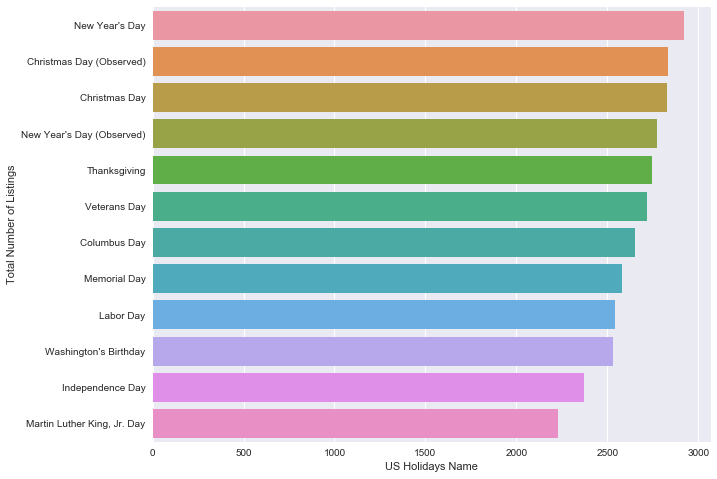

In [134]:
#checking which holiday has maximum listings
holiday_df = calendar1_df.groupby('us_holiday_name').listing_id.count()
holiday_df = holiday_df.reset_index()
holiday_df = holiday_df .sort_values('listing_id',ascending=[0])
holiday_df
plt.figure(figsize=(10,8))
ax = sns.barplot(y = "us_holiday_name", x = "listing_id", data=holiday_df)
ax.set(xlabel='US Holidays Name', ylabel='Total Number of Listings')

#### Check which holiday has maximum price

[Text(0,0.5,'Average Price'), Text(0.5,0,'US Holidays Name')]

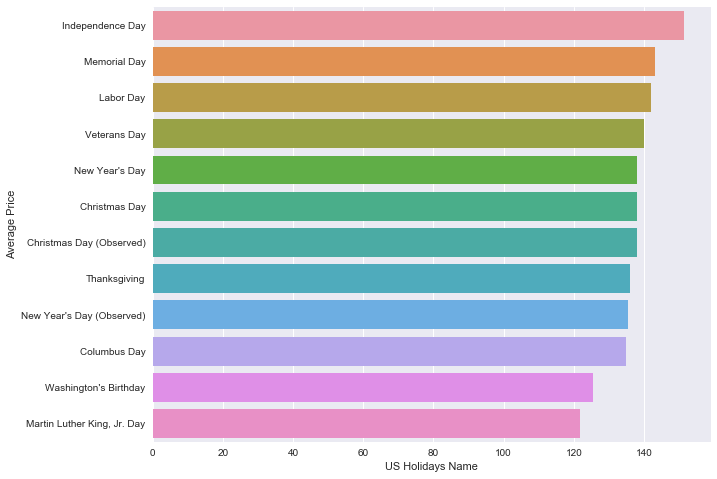

In [140]:
#checking which holiday has maximum prices
holidayPrice_df = calendar1_df.groupby('us_holiday_name').price.mean()
holidayPrice_df = holidayPrice_df.reset_index()
holidayPrice_df = holidayPrice_df.sort_values('price',ascending=[0])
holidayPrice_df.head(10)
plt.figure(figsize=(10,8))
ax = sns.barplot(y = "us_holiday_name", x="price", data=holidayPrice_df)
ax.set(xlabel='US Holidays Name', ylabel='Average Price')

In [142]:
# merge holiday listings and holiday price
merger = pd.merge(holiday_df,holidayPrice_df,on='us_holiday_name')
merger = merger.rename(columns={'listing_id':'number_Of_Listings'})
merger = merger.rename(columns={'price':'average_Price'})
merger

,us_holiday_name,number_Of_Listings,average_Price
0,New Year's Day,2922,138.126968
1,Christmas Day (Observed),2831,137.895797
2,Christmas Day,2829,137.974903
3,New Year's Day (Observed),2776,135.572767
4,Thanksgiving,2746,136.054989
5,Veterans Day,2718,140.070272
6,Columbus Day,2650,134.985660
7,Memorial Day,2583,143.233837
8,Labor Day,2544,142.087264
9,Washington's Birthday,2529,125.353895


#### Calculate diffrent price and log price per day

In [145]:
calendar1_df['log_price'] = calendar1_df.price.apply(lambda x:math.log(x))
calendar1_df.head()

,listing_id,date,available,price,day,year,month,day_name,holiday,us_holiday_name,log_price
0,241032,2016-01-04,t,85.0,4,2016,1,Monday,False,None,4.442651
1,241032,2016-01-05,t,85.0,5,2016,1,Tuesday,False,None,4.442651
9,241032,2016-01-13,t,85.0,13,2016,1,Wednesday,False,None,4.442651
10,241032,2016-01-14,t,85.0,14,2016,1,Thursday,False,None,4.442651
14,241032,2016-01-18,t,85.0,18,2016,1,Monday,True,"Martin Luther King, Jr. Day",4.442651


In [151]:
df1  = calendar1_df.groupby("listing_id")[["price"]].mean()
df1['log_price'] = calendar1_df.groupby("listing_id")[["log_price"]].mean()
df1["num_of_listing"] = calendar1_df.groupby("listing_id")[["listing_id"]].count()
df1.columns = ['mean_price','mean_log_price','num_of_listing']
df1.head()

,mean_price,mean_log_price,num_of_listing
listing_id,,,
3335,120.000000,4.787492,309
4291,82.000000,4.406719,365
5682,53.944984,3.983634,309
6606,92.849315,4.529830,365
7369,85.000000,4.442651,53


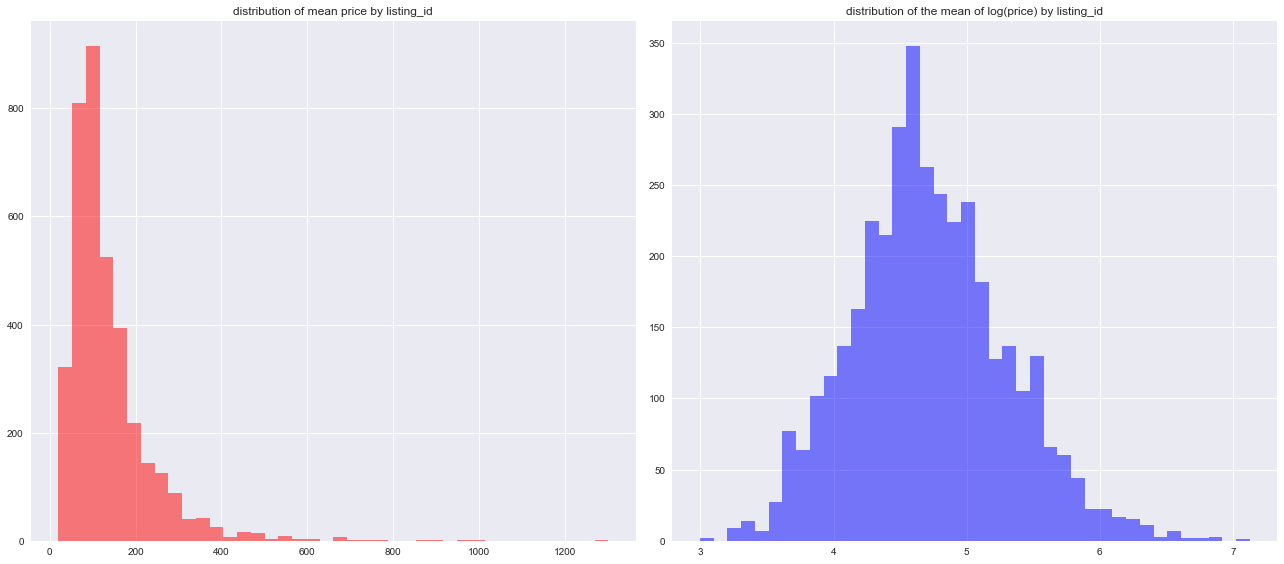

In [152]:
# Examine Distribution of average price by listing_id
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(18, 8))
ax1.hist(df1['mean_price'], color='red', bins=40, alpha=0.5)
ax1.set_title('distribution of mean price by listing_id')
ax2.hist(df1['mean_log_price'], color='blue', bins=40, alpha=0.5)
ax2.set_title('distribution of the mean of log(price) by listing_id')
plt.tight_layout()
plt.show()

In [153]:
calendar1_df['price_diff'] = 0
calendar1_df = calendar1_df.merge(df1,how='left',left_on='listing_id',right_on='listing_id')
calendar1_df['price_diff'] = calendar1_df['price'] - calendar1_df['mean_price']
calendar1_df.head()

,listing_id,date,available,price,day,year,month,day_name,holiday,us_holiday_name,log_price,price_diff,mean_price,mean_log_price,num_of_listing
0,241032,2016-01-04,t,85.0,4,2016,1,Monday,False,None,4.442651,0.0,85.0,4.442651,346
1,241032,2016-01-05,t,85.0,5,2016,1,Tuesday,False,None,4.442651,0.0,85.0,4.442651,346
2,241032,2016-01-13,t,85.0,13,2016,1,Wednesday,False,None,4.442651,0.0,85.0,4.442651,346
3,241032,2016-01-14,t,85.0,14,2016,1,Thursday,False,None,4.442651,0.0,85.0,4.442651,346
4,241032,2016-01-18,t,85.0,18,2016,1,Monday,True,"Martin Luther King, Jr. Day",4.442651,0.0,85.0,4.442651,346


In [164]:
calendar1_df[(calendar1_df['price_diff'] != 0)].head()

,listing_id,date,available,price,day,year,month,day_name,holiday,us_holiday_name,log_price,price_diff,mean_price,mean_log_price,num_of_listing
346,953595,2016-01-04,t,125.0,4,2016,1,Monday,False,None,4.828314,-45.931271,170.931271,5.121317,291
347,953595,2016-01-05,t,125.0,5,2016,1,Tuesday,False,None,4.828314,-45.931271,170.931271,5.121317,291
348,953595,2016-01-09,t,125.0,9,2016,1,Saturday,False,None,4.828314,-45.931271,170.931271,5.121317,291
349,953595,2016-01-10,t,125.0,10,2016,1,Sunday,False,None,4.828314,-45.931271,170.931271,5.121317,291
350,953595,2016-01-11,t,125.0,11,2016,1,Monday,False,None,4.828314,-45.931271,170.931271,5.121317,291


In [167]:
# Groupby datetime, get average price difference
final = calendar1_df.groupby(['date'], as_index = False)
final_sums = final['price_diff'].mean()
print ("Number of days average price difference was positive:", sum(final_sums['price_diff']>0))

Number of days average price difference was positive: 175


In [184]:
final_sums.head(10)

,date,price_diff
0,2016-01-04,-18.838351
1,2016-01-05,-18.076248
2,2016-01-06,-17.463632
3,2016-01-07,-15.613966
4,2016-01-08,-9.253081
5,2016-01-09,-8.802360
6,2016-01-10,-15.892563
7,2016-01-11,-17.305614
8,2016-01-12,-17.943899
9,2016-01-13,-17.315619


In [185]:
print('Maximum price differnce: ', final_sums.price_diff.max())
print('Minimum price differnce: ', final_sums.price_diff.min())

Maximum price differnce:  17.300085607737763
Minimum price differnce:  -18.83835077349453


In [172]:
final_sums['date'] = pd.to_datetime(final_sums['date'])

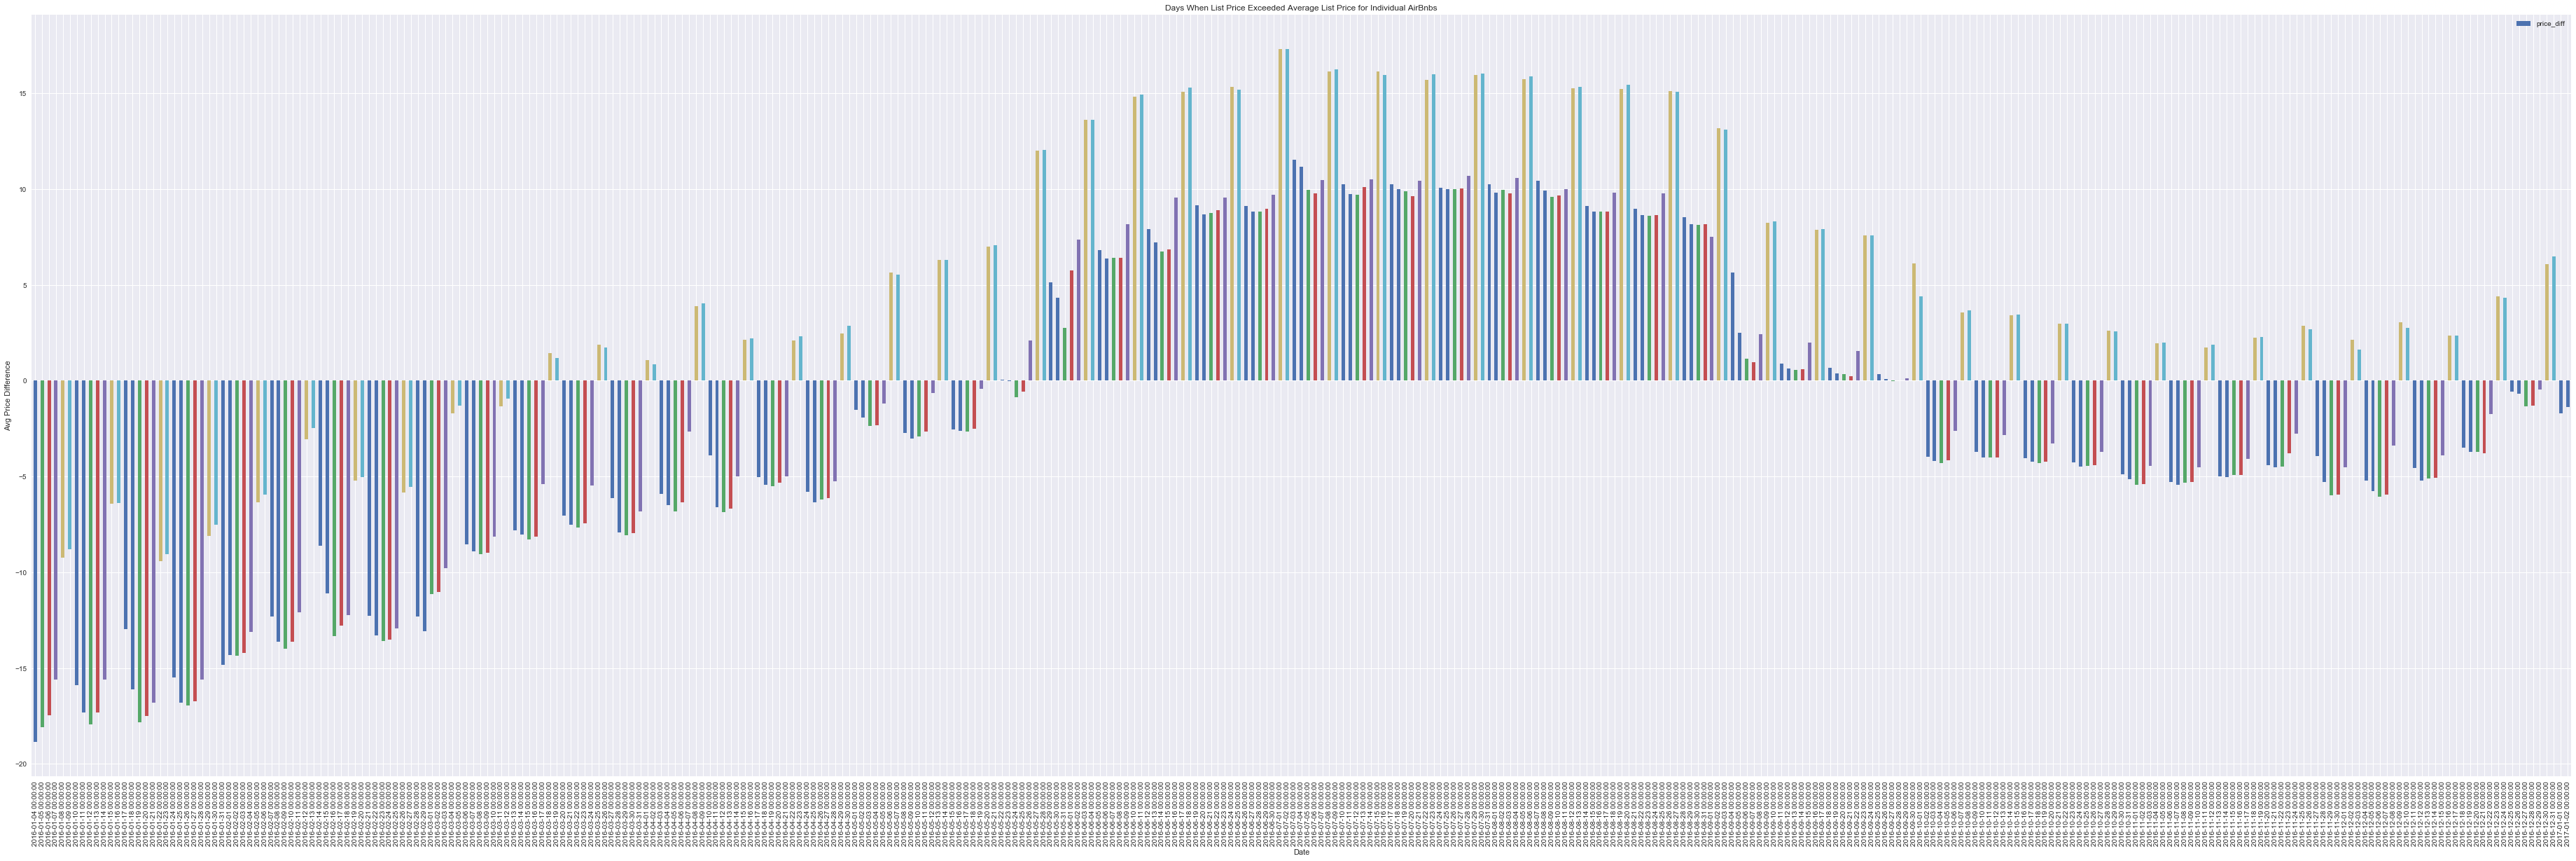

In [174]:
# Examine overall price difference trend
fig, ax = plt.subplots(1, 1, figsize=(65, 20))
final_sums.plot(kind='bar', x= 'date', y='price_diff', ax=ax)
ax.set_xticklabels(final_sums['date'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Days When List Price Exceeded Average List Price for Individual AirBnbs')
plt.show()

In [175]:
# Subset the data for easier viewing 
fall = final_sums[(final_sums['date'] > '2016-09-22') & (final_sums['date'] < '2016-12-22')] 
winter = final_sums[(final_sums['date'] > '2016-12-21') | (final_sums['date'] < '2016-03-20')] 
spring = final_sums[(final_sums['date'] > '2016-03-19') & (final_sums['date'] < '2016-06-21')] 
summer = final_sums[(final_sums['date'] > '2016-06-20') & (final_sums['date'] < '2016-09-23')]

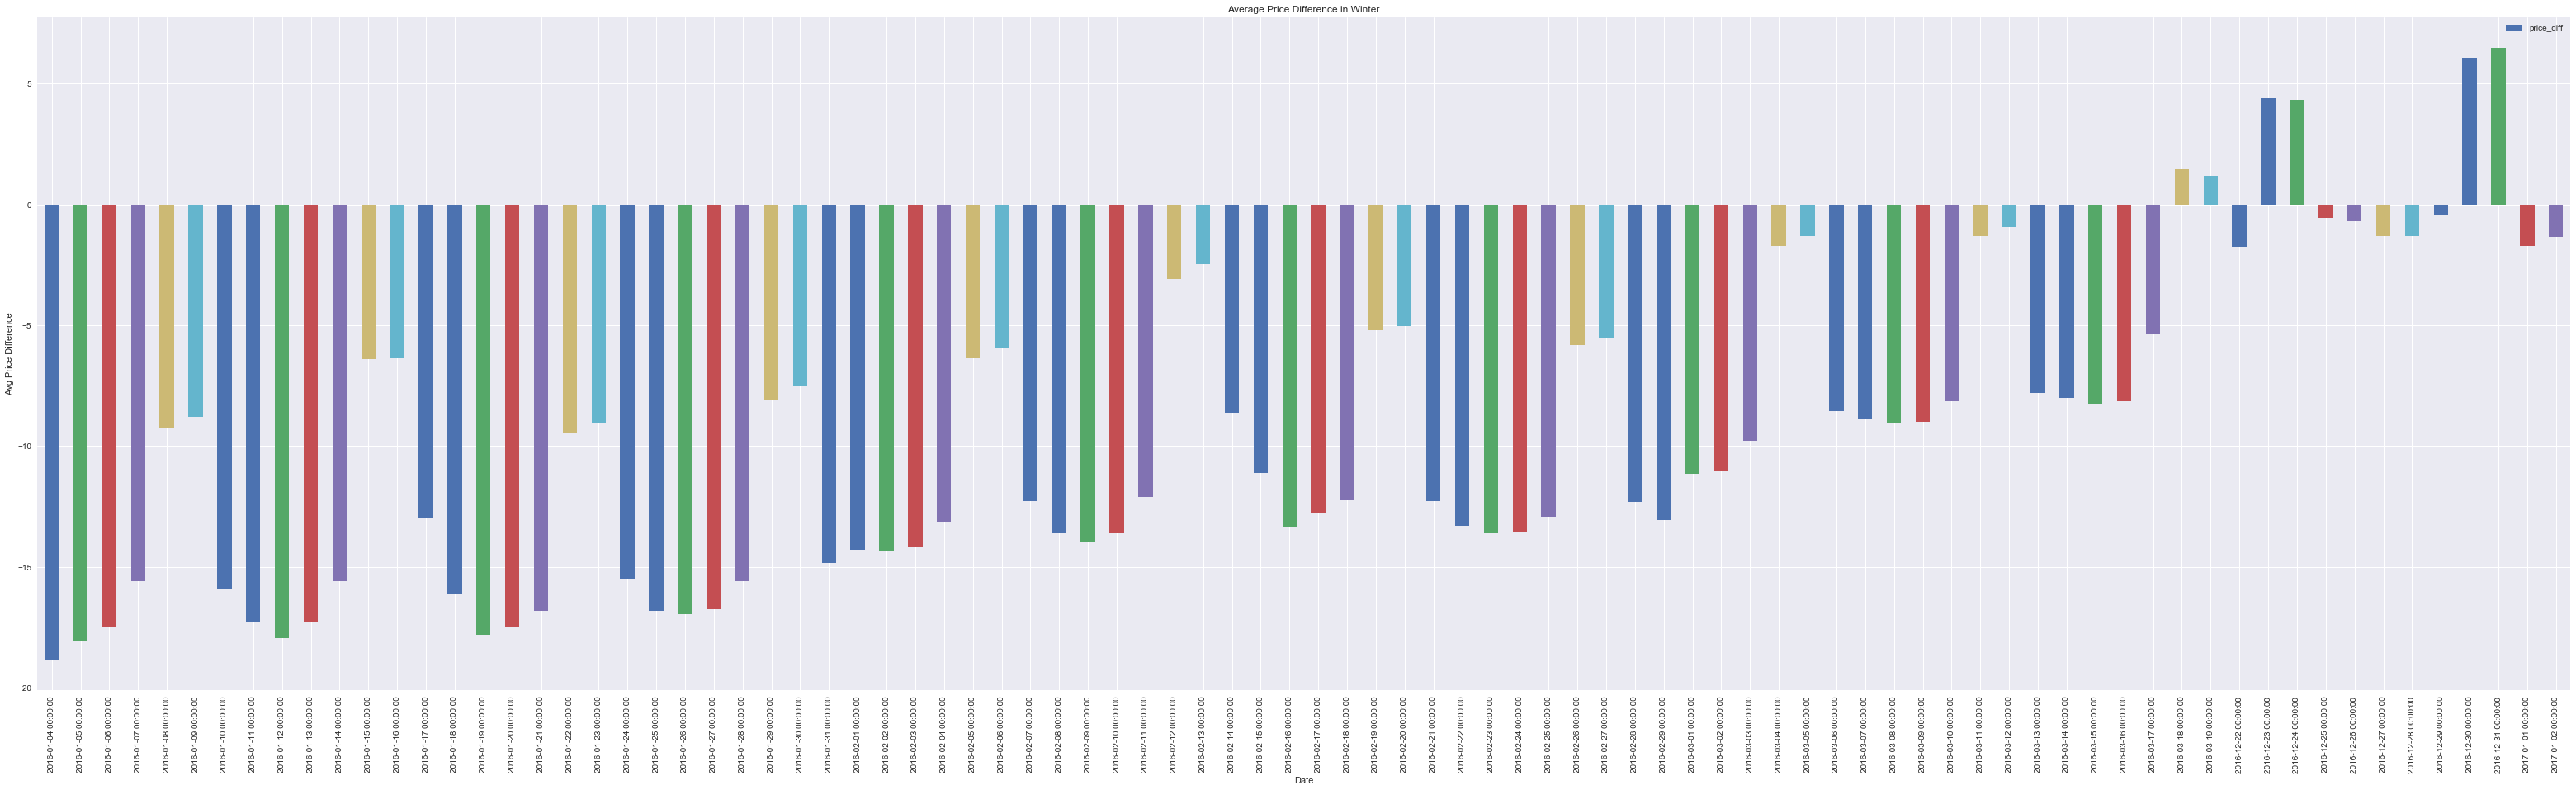

In [176]:
# WINTER 
fig, ax = plt.subplots(1, 1, figsize=(55, 15))
winter.plot(kind='bar', x= 'date', y='price_diff',  ax=ax)
ax.set_xticklabels(winter['date'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Winter')
plt.show()

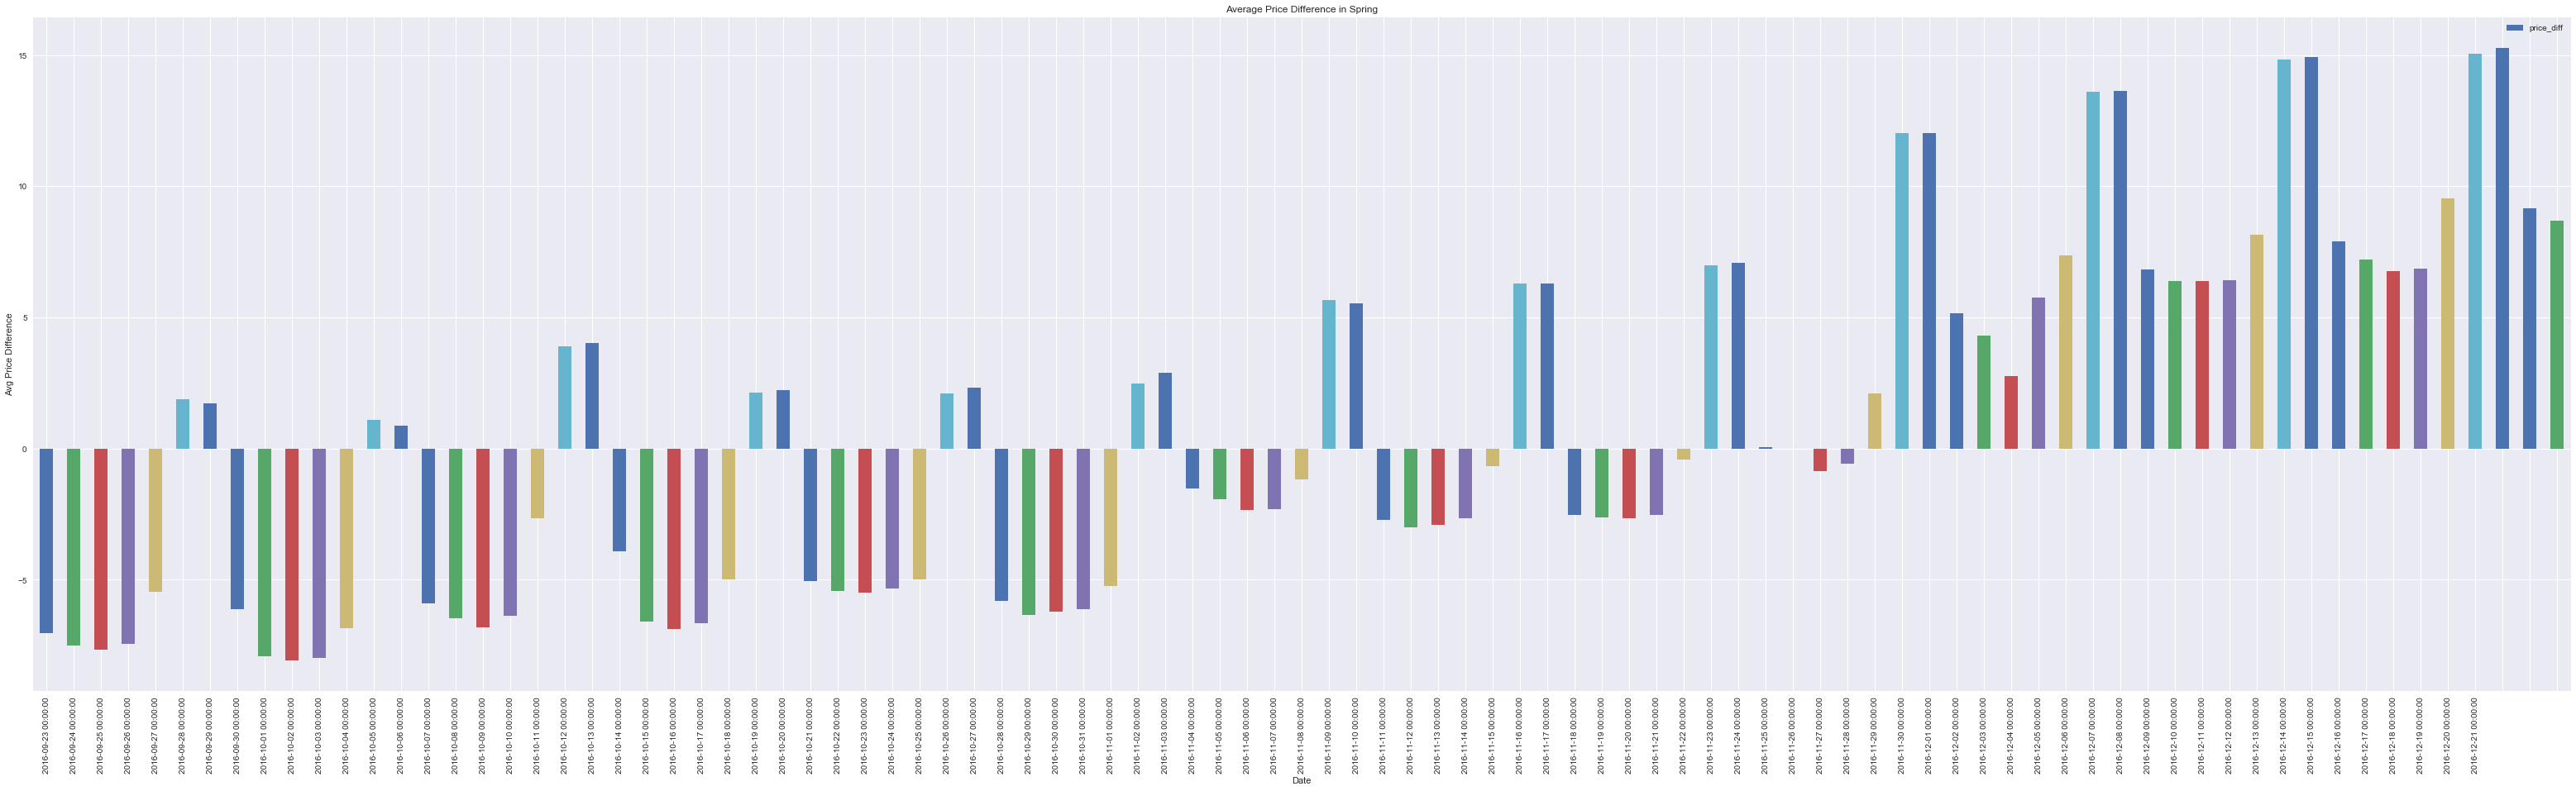

In [177]:
#SPRING
fig, ax = plt.subplots(1, 1, figsize=(55, 15))
spring.plot(kind='bar', x= 'date', y='price_diff',  ax=ax)
ax.set_xticklabels(fall['date'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Spring')
plt.show()

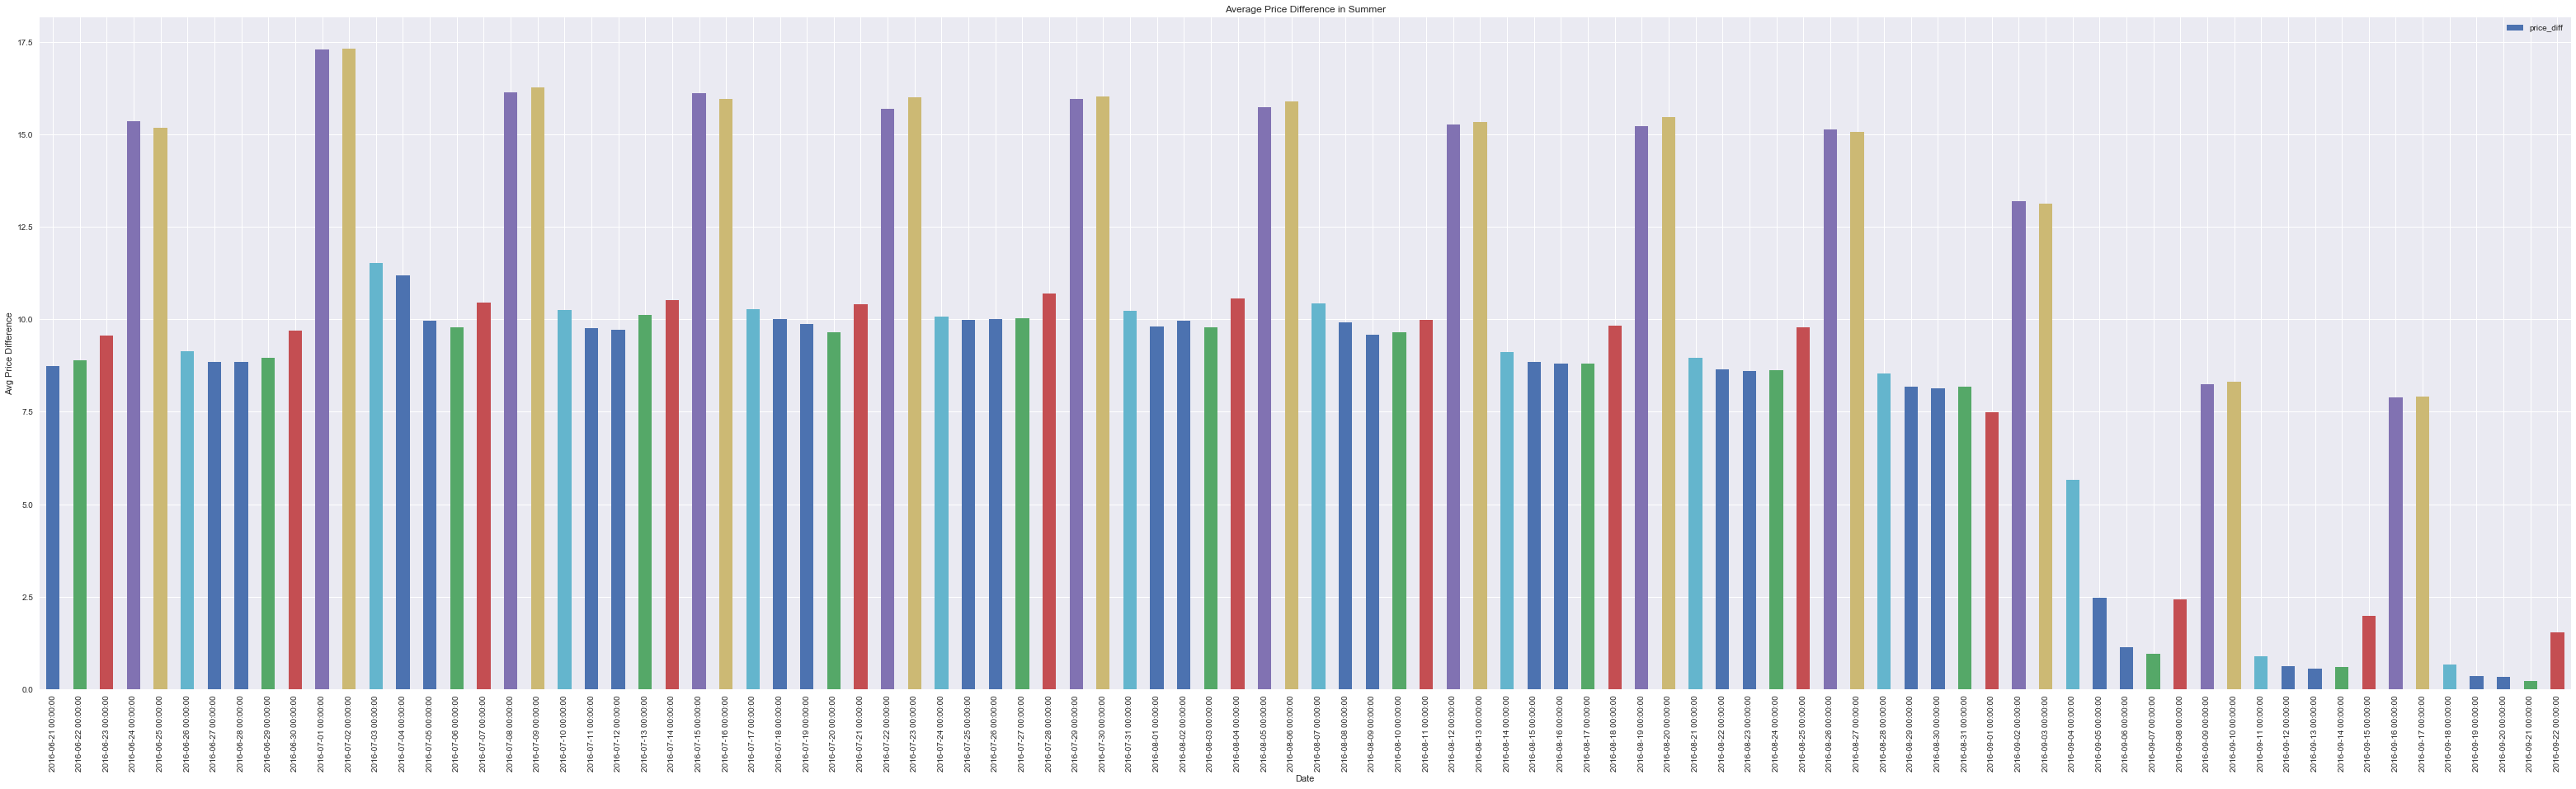

In [178]:
# SUMMER 
fig, ax = plt.subplots(1, 1, figsize=(55, 15))
summer.plot(kind='bar', x= 'date', y='price_diff',  ax=ax)
ax.set_xticklabels(summer['date'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Summer')
plt.show()

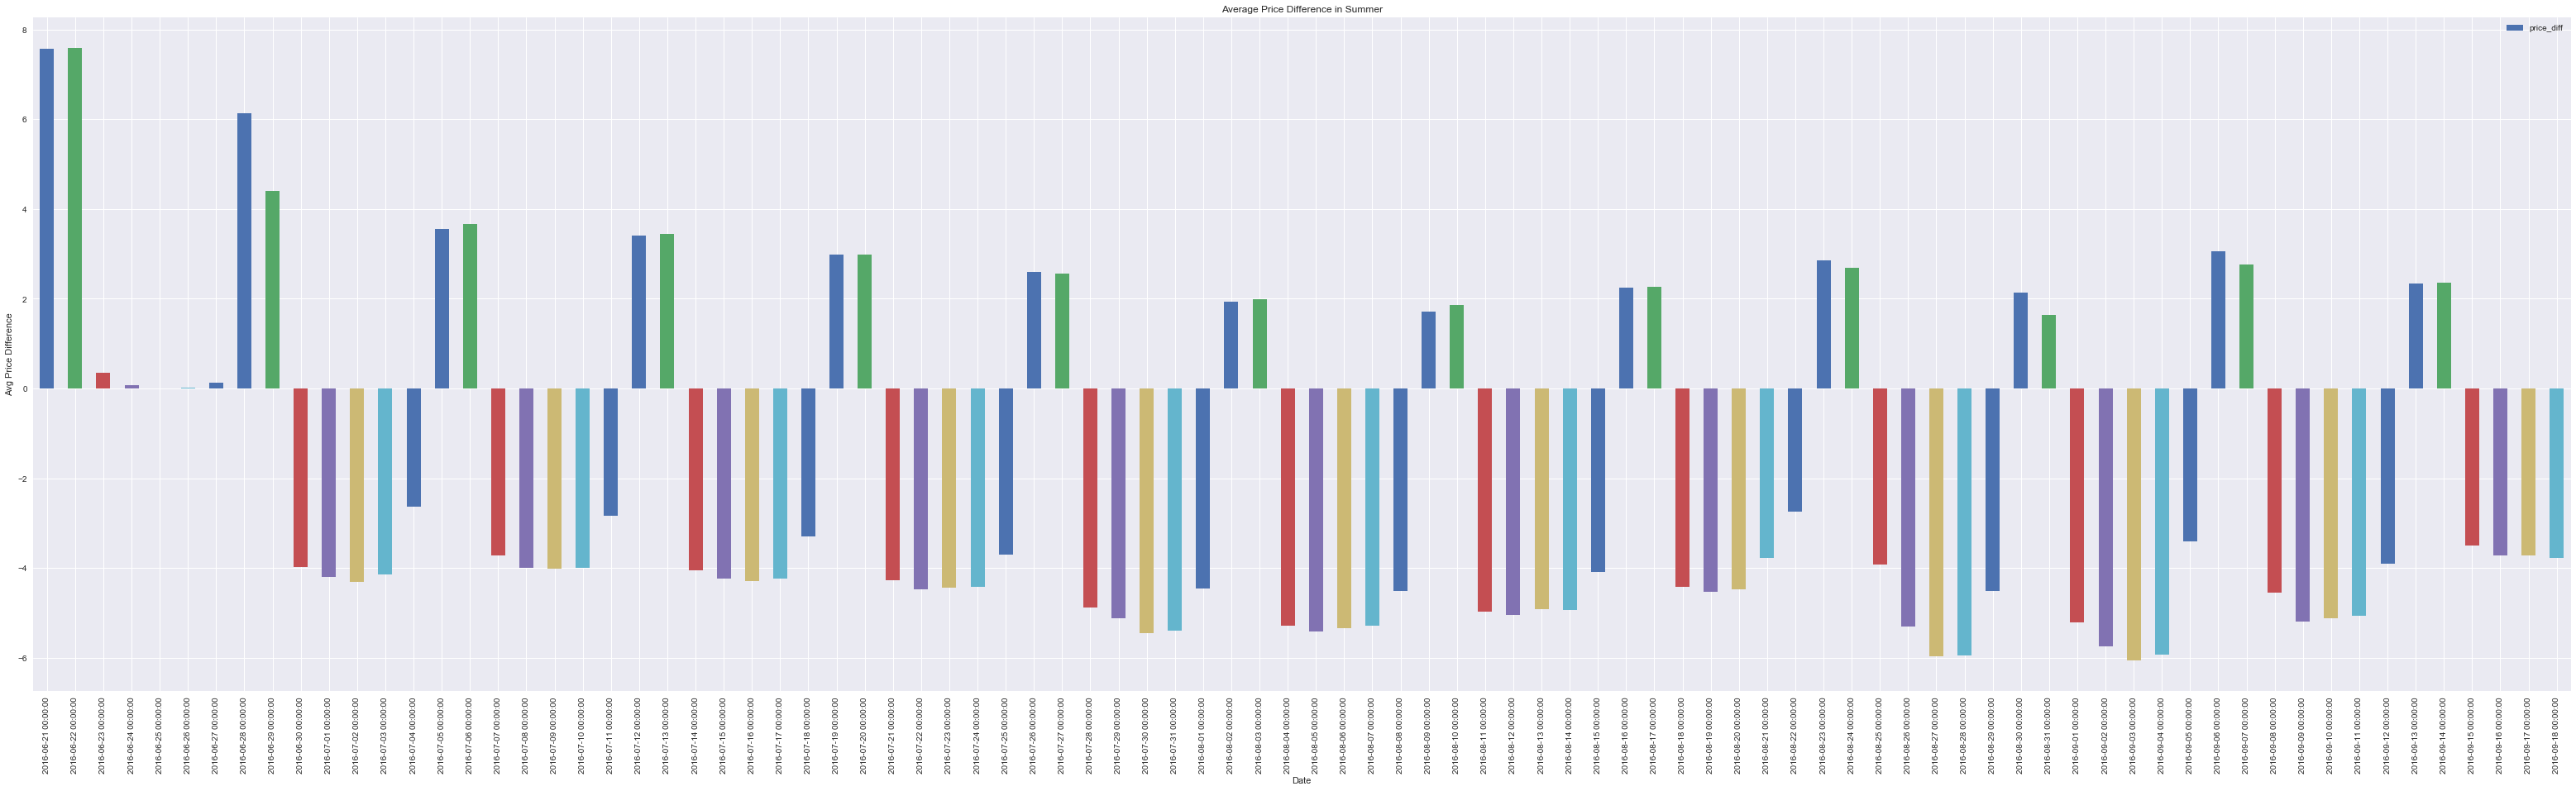

In [180]:
# FALL 
fig, ax = plt.subplots(1, 1, figsize=(55, 15))
fall.plot(kind='bar', x= 'date', y='price_diff',  ax=ax)
ax.set_xticklabels(summer['date'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Summer')
plt.show()

# Time series stationarity

In [214]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [219]:
# available listing by date
df1  = calendar1_df.groupby("date")[["listing_id"]].count()
# calculate sum and average of price by date
df1['sum'] = calendar1_df.groupby("date")[["price"]].sum()
df1["mean"]  = calendar1_df.groupby("date")[["price"]].mean()
df1.columns = ["Count", "Sum","Average"]
df1.index = pd.to_datetime(df1.index)
df1.head()

,Count,Sum,Average
date,,,
2016-01-04,1735,211819.0,122.085879
2016-01-05,1867,225312.0,120.681307
2016-01-06,1826,220815.0,120.928258
2016-01-07,1776,214823.0,120.958896
2016-01-08,1782,227456.0,127.640853


In [217]:
def draw_interactive_graph(mode):
    df1.index = pd.to_datetime(df1.index)
    decomposition = seasonal_decompose(df1[[mode]])
    trace4_1 = go.Scatter(
        x = decomposition.observed.index, 
        y = decomposition.observed[mode],
        name = "Observed"
    )
    trace4_2 = go.Scatter(
        x = decomposition.trend.index,
        y = decomposition.trend[mode],
        name = "Trend"
    )
    trace4_3 = go.Scatter(
        x = decomposition.seasonal.index,
        y = decomposition.seasonal[mode],
        name = "Seasonal"
    )
    trace4_4 = go.Scatter(
        x = decomposition.resid.index,
        y = decomposition.resid[mode],
        name = "Resid"
    )

    fig = py.tools.make_subplots(rows=4, cols=1, subplot_titles=('Observed', 'Trend',
                                                              'Seasonal', 'Residiual'))
    # append trace into fig
    fig.append_trace(trace4_1, 1, 1)
    fig.append_trace(trace4_2, 2, 1)
    fig.append_trace(trace4_3, 3, 1)
    fig.append_trace(trace4_4, 4, 1)

    fig['layout'].update( title='Descompose with TimeSeries')
    offline.iplot(fig)

In [220]:
draw_interactive_graph("Average")

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]

